### comparison of average Citi Bike trip lengths during the winter and summer

In [1]:
__author__ = 'uak211'
import pandas as pd
import numpy as np
import os
import requests
import zipfile
import io
from scipy.stats import mannwhitneyu, rankdata, tiecorrect, norm
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

#### download data, concatenate dfs, select columns of interest

In [ ]:
# start here if downloading data for the first time
def get_citibike_data(datestring):
    '''
    Downloads and unzips citibike csv data into the $PUIDATA directory.
    Arguments:
        date string in format yyyymm
    ''' 
    file_root = '{}-citibike-tripdata'.format(datestring)
    if not ('2018' or '2017') in datestring:
        url = 'https://s3.amazonaws.com/tripdata/{}.zip'.format(file_root)
    else:
        url = 'https://s3.amazonaws.com/tripdata/{}.csv.zip'.format(file_root)

    r = requests.get(url)
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content), 'r')
    zip_ref.extractall(os.getenv('PUIDATA'))
    zip_ref.close()

In [ ]:
winter_date = '201801'
summer_date = '201807'
get_citibike_data(winter_date)
get_citibike_data(summer_date)

In [2]:
# start here if the data already exists locally
winter_date = '201801'
summer_date = '201807'
summer_file = '{}-citibike-tripdata'.format(summer_date)
winter_file = '{}-citibike-tripdata'.format(winter_date)
summer_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), summer_file))
winter_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), winter_file))

In [3]:
dfs = [winter_bikes, summer_bikes]
bikes = pd.concat(dfs)
bikes.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [4]:
drop_cols = ['start station id', 'stoptime','start station name',
             'start station latitude', 'start station longitude', 
            'end station id', 'end station name', 'end station latitude', 
             'end station longitude', 'bikeid', 'birth year', 'gender']
bikes.drop(drop_cols, axis = 1, inplace = True)

#### HYPOTHESES:
null: the average length of a citibike subscriber's trip is the same or longer during a winter month than a summer month

$H_0: \overline{L}_{\mathrm{summer}} <= \overline{L}_{\mathrm{winter}}$

$H_1: \overline{L}_{\mathrm{summer}} > \overline{L}_{\mathrm{winter}}$

statistical significance level: $\alpha=0.05$

#### further data prep
* dummy code winter/summer variable
* limit dataset to subscribers
* dropping nulls

In [5]:
bikes['summer_month'] = bikes.starttime.str.contains('2018-07')*1
bikes = bikes[bikes.usertype.str.contains('Customer') == False]
bikes = bikes.dropna(how = 'any')

In [6]:
summer = bikes.loc[bikes['summer_month'] == 1]
winter = bikes.loc[bikes['summer_month'] == 0]

#### plot of the distribution of trip lengths

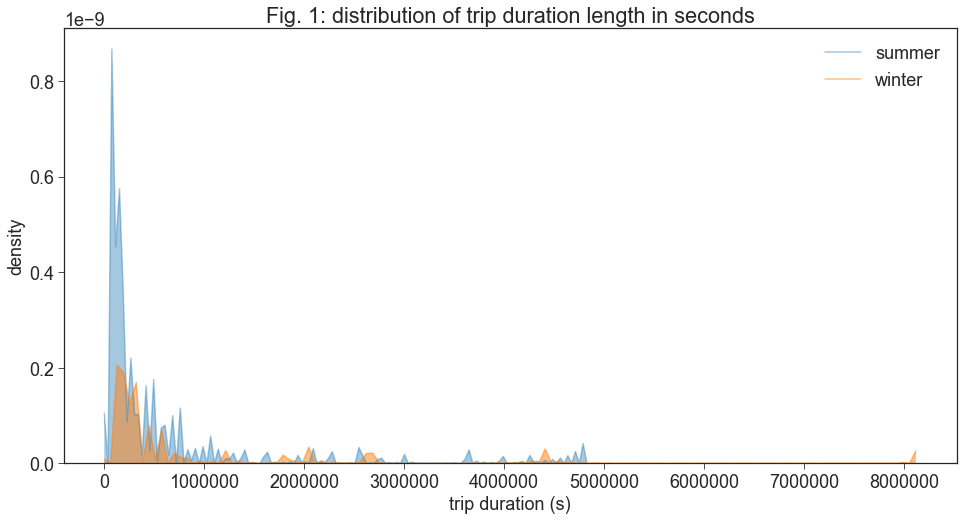

In [7]:
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize = (16, 8))
ax.set(xlabel = 'trip duration (s)', ylabel = 'density', 
       title = 'Fig. 1: distribution of trip duration length in seconds')
sn.kdeplot(summer['tripduration'], bw = 12, shade = True, label = 'summer', alpha = 0.4, gridsize = 125)
sn.kdeplot(winter['tripduration'], bw = 12, shade = True, label = 'winter', alpha = 0.5, gridsize = 125)
plt.legend();

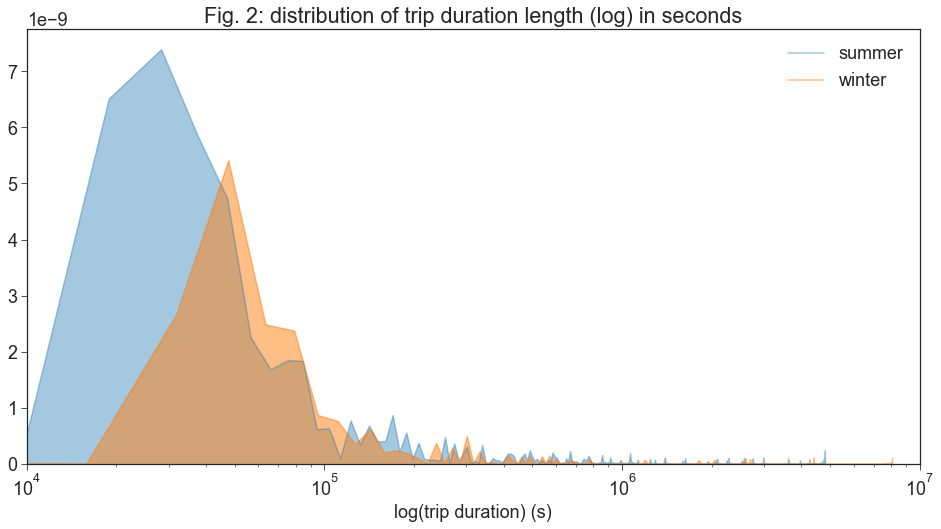

In [12]:
# with log-normal scale
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize = (16, 8))
ax.set(xlim = [10000, 10000000], xlabel = 'log(trip duration) (s)', ylabel = '', 
       title = 'Fig. 2: distribution of trip duration length (log) in seconds')
ax.set_xscale('log')
sn.kdeplot(summer['tripduration'], bw = 12, shade = True, label = 'summer', alpha = 0.4, gridsize = 425)
sn.kdeplot(winter['tripduration'], bw = 12, shade = True, label = 'winter', alpha = 0.5, gridsize = 425)
plt.legend();

#### mann-whitney ranked sum test
this test allows us to determine whether the average trip length in the summer is less than or equal to the average winter trip length, as our null hypothesis claims.

In [9]:
u, prob = mannwhitneyu(summer.tripduration, winter.tripduration, alternative = 'less') 
u, prob # we have a high p-value and cannot reject the null

(635512324086.0, 1.0)

In [10]:
# compare result to test statistic critical value
n_1 = len(summer)
n_2 = len(winter)
mu = 0.5 * n_1 * n_2
ranked = rankdata(np.concatenate((summer.tripduration, winter.tripduration)))
t = tiecorrect(ranked) 
sigma = np.sqrt(t*n_1*n_2*(n_1+n_2+1)/12.0) 
z = 1.64 # critical value for one-tailed test for alpha = 0.05
u_crit = mu - z * sigma - 0.5
u_crit # if our test u is less than the critical value, we can reject the null hypothesis

566755956783.9368

In [11]:
z = (u - mu)/sigma
pval = norm.cdf(z)
z, pval

(144.95716544156244, 1.0)

#### our u value is greater than our critical value for $\alpha$ = 0.05, so we cannot reject the null hypothesis.